# 4 Point Correlation Function

This notebook will be my space to attempt writing a functioning 4PCF code that will be applied to a small subset of the ISM. 

In [13]:
import numpy as np
from subprocess import call
import astropy.io.fits as pyf
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as fitter
import time

# plt.style.use("dark_background")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 22

## I) Make Bins & Kernels

We work with a subset of the $256^3$ data cube because this is being tested on a laptop. We will only worry about a $64^3$ subset of the total cube. 

The first step is to make the spherical harmonic kernels tailored to the size of our data cubes and our choice of bins. I will use 4 radial bins linearly spaced between 1 and 32 pixels. I am doing this small subset and amount of bins so my laptop can handle all the calculations. These kernels can be reused for any input data of our chosen size (64<sup>3</sup> in this case), so we give them the identifier `demo` to allow them to be retrieved later. 

In [2]:
save_name = 'demo'
eps = 1e-15
ell_max = 5
nbins = 4
#don't set it to zero, because spherical harmonics are ill-defined at the origin
bin_min = 1-1e-5
#radius from the origin.
bin_max = 32+1e-5

switch = {
    'LIN' : np.linspace(bin_min, bin_max, nbins+1),
    'INV' : 1./np.linspace(1./bin_min, 1./bin_max, nbins+1),
    'LOG' : np.exp(np.linspace(np.log(bin_min), np.log(bin_max), nbins+1))
}
bin_edges = switch['LIN']
ld_one_d = 64

We create three $64^3$ arrays containing $(x,y,z)$ positions, with the origin being in the middle. These and arrays containing $r$ and $r^2$ will be used to sort voxels into bins and calculate the spherical harmonics.

In [3]:
x = np.linspace(-ld_one_d/2, ld_one_d/2-1 , ld_one_d)
xsq = x*x
m_center = np.where(x==0)[0][0]
X, Y, Z = np.meshgrid(x, x, x, indexing='ij')
X = -X
Y = -Y
Z = -Z
Xsq, Ysq, Zsq = np.meshgrid(xsq, xsq, xsq,indexing='ij')
#PRECOMPUTE POWERS OF ARRAYS AND COMBINATIONS (e.g. x - iy).
Rsq = Xsq+Ysq+Zsq
R = np.sqrt(Rsq)
del Rsq
zero_ind = np.where(R==0)
R[zero_ind] = eps
X[zero_ind] = eps
Y[zero_ind] = eps
Z[zero_ind] = eps

The above code also calculates how many voxels fall into each of the radial bins we defined. While the number of voxels in a bin is approximately $4 \pi r^2 \Delta r$, it will be useful to know the exact number of voxels when normalizing the 4PCF. We show a slice of the $64^3$ cube and color voxels by the bin they fall in. Note that the data cube will be treated as periodic, so we do not want bins that extend farther than half the box width.

In [4]:
boundsandnumber = np.zeros((2, nbins+1))
boundsandnumber[0,:] = bin_edges
for i in range(nbins):
    boundsandnumber[1,i] = np.sum(np.logical_and(R >= bin_edges[i],
                                               R < bin_edges[i+1]))
np.save('bin_bounds_and_pixel_number_'+save_name+'.npy',boundsandnumber)

In [5]:
xdata,ydata = range(nbins), boundsandnumber[1,0:nbins]

def model_quad(x, a, b, c):
    return a + b*x + c*x*x

par0    = np.array([2800.0, 0.0, 1.0]) # initial guess for parameters
par, cov = fitter.curve_fit(model_quad, xdata, ydata, par0) #fitter.curve_fit takes in the model, x,y data, guess, and sigma

# par arrays contains the values of parameters. cov is the covariance matrix
# decode it now
a = par[0]
ea = np.sqrt(cov[0,0])
print('a={0:6.3f}+/-{1:5.3f}'.format(a,ea))
b = par[1]
eb = np.sqrt(cov[1,1])
print('b={0:6.3f}+/-{1:5.3f}'.format(b,eb))
c = par[2]
ec = np.sqrt(cov[2,2])
print('c={0:6.3f}+/-{1:5.3f}'.format(c,ec))


a=2786.250+/-59.935
b=7547.750+/-96.250
c=5759.250+/-30.746


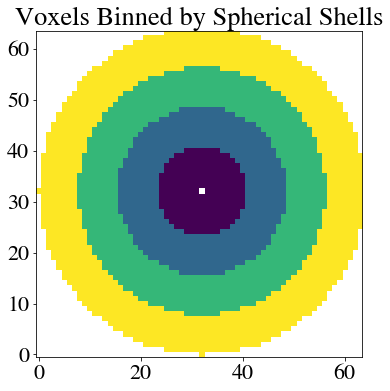

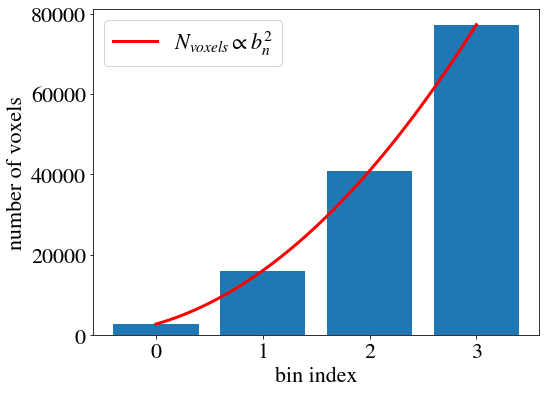

In [6]:

plt.figure(figsize=(6,6))
plt.title("Voxels Binned by Spherical Shells")
whichbin = np.full_like(R, float('nan'))
for i in range(nbins):
    mask = np.logical_and(R >= bin_edges[i], R < bin_edges[i+1])
    whichbin[mask] = i
plt.imshow(whichbin[ld_one_d//2,:,:], origin='lower')
plt.show()

plt.figure(figsize=(8,6))
plt.bar(range(nbins), boundsandnumber[1,0:nbins])
xfit = np.linspace(0,nbins-1,50)
plt.plot(xfit,model_quad(xfit,par[0],par[1], par[2]),'r-', linewidth=3, label='$N_{voxels} \propto b_n^2$')
plt.xticks(range(nbins))
plt.xlabel('bin index')
plt.ylabel('number of voxels')
plt.legend()
plt.show()

(5,)

## II) Calculate & Store $Y_{\ell m}$ for $64^3$ cube

In [21]:
def ylm_save(ylm, ell, m):
    np.save('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy',ylm)#zs: to work on my laptop.
    del ylm

def ylm_transform_save(ylm_on_shell, ell, m, i):
    FT = np.fft.fftn(np.fft.fftshift(ylm_on_shell))
    np.save('YLMtilde_'+save_name+'_'+str(ell)+'_'+str(m)+'_bin_'+str(i)+'.npy',FT)
    del FT

In [22]:
#COMPUTE YLMS SEQUENTIALLY AND SAVE.

"""
xmiydivr = e^(-iφ)sin(θ) = (x - iy)/r
zdivr = cos(θ) = z/r

xmidivrsq = e^(-2iφ)sin^2(θ) = [(x - iy)/r]^2
zdivrsq = cos^2(θ) = [z/r]^2

..cu means cubed

..ft means to the fourth power

..fi means to the fifth power

"""


#ell, m = 0,0
y00 =.5*(1./np.pi)**.5*np.ones((ld_one_d,ld_one_d,ld_one_d))
ylm_save(y00, 0, 0)
del y00

#ell, m = 1, -1
xdivr = X/R
del X
ydivr = Y/R #we'll need these as individuals later anyway.
del Y
xmiydivr = xdivr - 1j*ydivr
y1m1 = .5*np.sqrt(3./(2.*np.pi))*xmiydivr
ylm_save(y1m1, 1, 1)
del y1m1

#ell, m = 1, 0
zdivr = Z/R
del Z
y10 = .5*np.sqrt(3./np.pi)*zdivr
ylm_save(y10, 1, 0)
del y10

#ell, m = 2, -2
xmiydivrsq = xmiydivr*xmiydivr
y2m2 = .25*np.sqrt(15./(2.*np.pi))*xmiydivrsq
ylm_save(y2m2, 2, 2)
del y2m2

#ell, m = 2, -1
y2m1 = .5*np.sqrt(15./(2.*np.pi))*xmiydivr*zdivr
ylm_save(y2m1, 2, 1)
del y2m1

#ell, m = 2, 0
xdivrsq = xdivr*xdivr
ydivrsq = ydivr*ydivr
zdivrsq = zdivr*zdivr
y20 = .25*np.sqrt(5./np.pi)*(2.*zdivrsq-xdivrsq-ydivrsq)
ylm_save(y20, 2, 0)
del y20

#ell, m = 3, -3
xmiydivrcu = xmiydivr*xmiydivrsq
y3m3 = .125*np.sqrt(35./np.pi)*xmiydivrcu
ylm_save(y3m3, 3, 3)
del y3m3

#ell, m = 3, -2
y3m2 = .25*np.sqrt(105./(2.*np.pi))*xmiydivrsq*zdivr
ylm_save(y3m2, 3, 2)
del y3m2

#ell, m = 3, -1
y3m1 = .125*np.sqrt(21./np.pi)*(xmiydivr*(4.*zdivrsq-xdivrsq-ydivrsq))
ylm_save(y3m1, 3, 1)
del y3m1

#ell, m = 3, 0
y30 = .25*np.sqrt(7./np.pi)*(zdivr*(2.*zdivrsq-3.*xdivrsq-3.*ydivrsq))
ylm_save(y30, 3, 0)
del y30

#ell, m = 4, -4
xmiydivrft = xmiydivr*xmiydivrcu
y4m4 = .1875*np.sqrt(35./(2.*np.pi))*xmiydivrft
ylm_save(y4m4, 4, 4)
del y4m4

#ell, m = 4, -3
y4m3 = .375*np.sqrt(35./np.pi)*xmiydivrcu*zdivr
ylm_save(y4m3, 4, 3)
del y4m3

#ell, m = 4, -2
y4m2 = .375*np.sqrt(5./(2.*np.pi))*xmiydivrsq*(7.*zdivrsq-1)
ylm_save(y4m2, 4, 2)
del y4m2

#ell, m = 4, -1
y4m1 = .375*np.sqrt(5./np.pi)*xmiydivr*zdivr*(7.*zdivrsq-3.)
ylm_save(y4m1, 4, 1)
del y4m1

#ell, m = 4, 0
zdivrft = zdivrsq*zdivrsq
y40 = .1875*np.sqrt(1./np.pi)*(35.*zdivrft-30.*zdivrsq+3.)
ylm_save(y40, 4, 0)
del y40

#ell, m = 5, -5
xmiydivrfi = xmiydivr*xmiydivrft
y5m5 = (3./32.)*np.sqrt(77./np.pi)*xmiydivrfi
ylm_save(y5m5, 5, 5)
del y5m5

#ell, m = 5, -4
y5m4 = (3./16.)*np.sqrt(385./(2.*np.pi))*xmiydivrft*zdivr 
ylm_save(y5m4, 5, 4)
del y5m4

#ell, m = 5, -3
y5m3 = (1./32.)*np.sqrt(385./np.pi)*xmiydivrcu*(9.*zdivrsq-1.)
ylm_save(y5m3, 5, 3)
del y5m3

#ell, m = 5, -2
zdivrcu = zdivr*zdivrsq
y5m2 = (1./8.)*np.sqrt(1155./(2.*np.pi))*xmiydivrsq*(3.*zdivrcu-zdivr)
ylm_save(y5m2, 5, 2)
del y5m2

#ell, m = 5, -1
y5m1 = (1./16.)*np.sqrt(165./(2.*np.pi))*xmiydivr*(21.*zdivrft-14.*zdivrsq+1.)
ylm_save(y5m1, 5, 1)
del y5m1

#ell, m = 5, 0
zdivrfi = zdivr*zdivrft
y50 = (1./16.)*np.sqrt(11./np.pi)*(63.*zdivrfi-70.*zdivrcu+15.*zdivr)
ylm_save(y50, 5, 0)
del y50

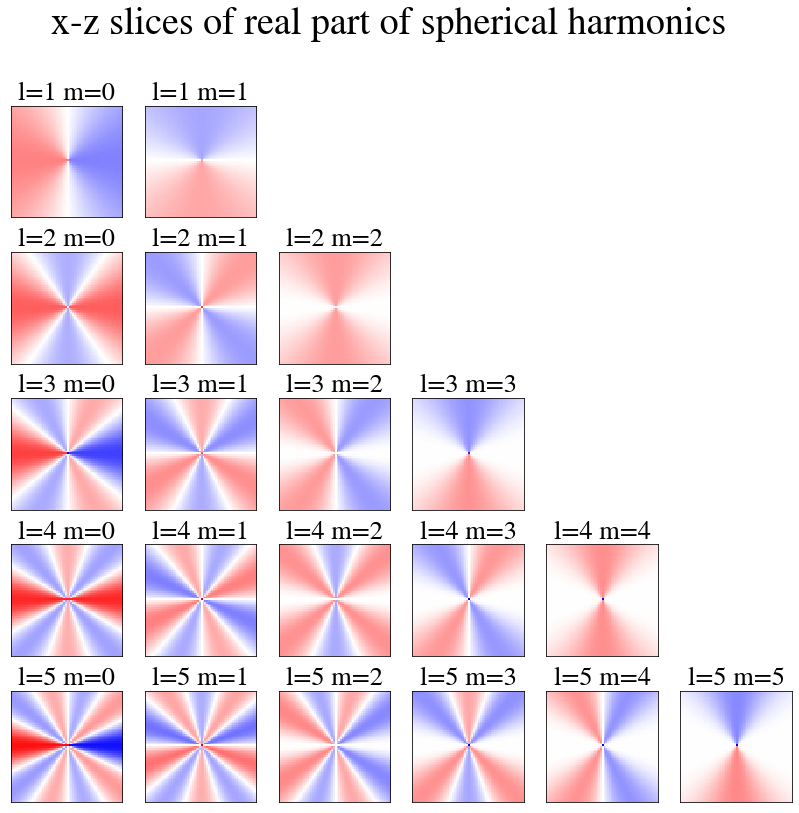

In [28]:
plt.figure(figsize=(14,13))
for ell in range(1, ell_max+1):
    for m in range(0, ell+1):
        plt.subplot(ell_max, ell_max+1, (ell-1)*(ell_max+1)+m+1)
        ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy')
        plt.imshow(ylm[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr', origin='lower')
        plt.xticks([])
        plt.yticks([])
        plt.title('l='+str(ell)+' m='+str(m))
plt.suptitle('x-z slices of real part of spherical harmonics', fontsize='xx-large')
plt.show()

## III) Bin Spherical Harmonics $Y_{\ell m} \Theta^b(r)$ 

We want to convolve the input data with these spherical harmonics restricted to each of our radial bins, $Y_{\ell m}(\hat{r}) \Theta^b(r)$, where the radial bins are indexed by $b$. The binned spherical harmonics for $(\ell, m)=(1,0)$ are shown in the figure below.

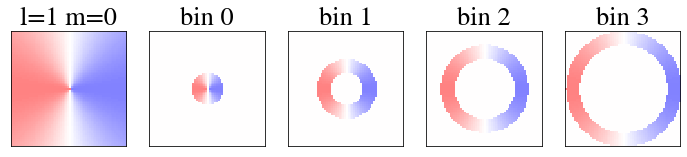

In [31]:
ell = 1
m = 0
ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy')
plt.figure(figsize=(12,8))
plt.subplot(1,nbins+1,1)
plt.imshow(ylm[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr')
plt.xticks([])
plt.yticks([])
plt.title('l='+str(ell)+' m='+str(m))
for i in range(nbins):
    rib = np.where((R >= bin_edges[i]) & (R < bin_edges[i+1]))
    ylm_on_shell = np.zeros((ld_one_d, ld_one_d, ld_one_d)) + 0j
    ylm_on_shell[rib] = ylm[rib]
    plt.subplot(1,nbins+1,i+2)
    plt.imshow(ylm_on_shell[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    plt.title('bin '+str(i))
plt.show()

In [32]:
for ell in range(0, ell_max+1):
    for m in range(0, ell+1):
        print("ell, m = ", ell, m)
        #do one ylm at a time to save lots of accessing memory
        ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy') 
        for i in range(nbins):
            print("bin i = ", i)
            #where is radius in bin?
            rib = np.where((R >= bin_edges[i]) & (R < bin_edges[i+1]))
            ylm_on_shell = np.zeros((ld_one_d, ld_one_d, ld_one_d)) + 0j
            ylm_on_shell[rib] = ylm[rib]
            del rib
            ylm_transform_save(ylm_on_shell, ell, m, i)
            del ylm_on_shell
        if 'ylm' in globals():
            del ylm
        file_to_rm = 'ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy'
        call(["rm", file_to_rm])

ell, m =  0 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  1 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  1 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 3
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 3
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 4
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  5 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  5 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  5 2


## IV) Import CATS Data

use `wget` to pull data from the CATS database

In [ ]:
# !wget https://users.flatironinstitute.org/~bburkhart/data/CATS/MHD/256/b.1p.32/t_800/dens_t800.fits.gz
# !ls

In [21]:
save_name = 'GRF_scaled'
kernel_name = 'demo'
# file = save_name+'.fits.gz'

# hdulist = pyf.open(file)
# data = hdulist[0].data.astype(np.float64) # hopefully 64 is enough?

data = np.load('../Testing/deltar_scaled.npy')

#FT OF SHIFTED DATA
normalized = False # do log normalization
if normalized:
    data = (np.log(data) - np.mean(np.log(data)))/np.std(np.log(data))
ft_data = np.fft.fftn(data)

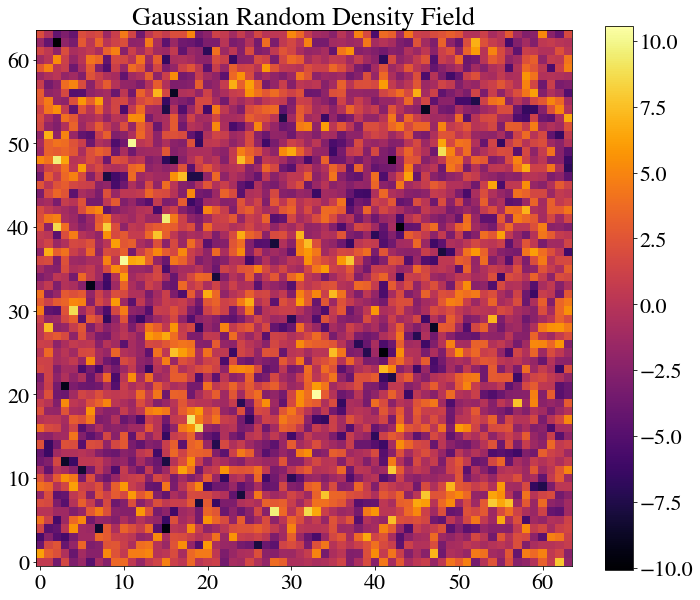

In [22]:
plt.figure(figsize=(12,10))
plt.title("Gaussian Random Density Field")
plt.imshow(data[32,:,:],cmap='inferno', origin='lower') #place origin in the lower left corner
plt.colorbar()
plt.show()

We only want a subset of the $256^3$ cube.

In [9]:
# data = data[:64,:64,:64] # shift origin to center of main box
# ft_data = ft_data[:64,:64,:64]

# plt.figure(figsize=(12,10))
# plt.title("Density Field of Turbulent ISM")
# plt.imshow(data[64//2,:,:], cmap='inferno', origin='lower')
# plt.colorbar()
# plt.show()

## V) Calculate Spherical Harmonic Coefficients $a_{\ell m}^{b} (\mathbf{x})$

We then convolve the data $\delta$ with the binned spherical harmonics $Y_{\ell m}(\hat{r}) \Theta^b(r)$ to yield $a_{\ell m}^{b} (\mathbf{x})$ cubes, where $b$ is the bin index. The Fourier transforms of the binned spherical harmonics are on disk, so we can perform the convolution by using the convolution theorem

$a_{\ell m}^b(\mathbf{x}) = \mathcal{F}^{-1}\left[\mathcal{F}[\delta] \times \mathcal{F}[Y_{\ell m}(\hat{r}) \Theta^b(r)]\right](s)$

In [23]:
#CONVOLUTION OF DATA AND SPH_KERNEL AT A GIVEN BIN
for l in range(0, ell_max+1, 1):
    for m in range(0,l+1, 1):
        for bin in range(0, nbins, 1):
            print("l, m, bin =", l, m, bin)
            #load ft of bsph_kernels
            bsph_kernel = np.load('YLMtilde_'+kernel_name+'_'+str(l)+'_'+str(m)+
                                '_bin_'+str(bin)+'.npy')
            conv = np.fft.ifftn(ft_data*bsph_kernel)
            del bsph_kernel
            #a_lm^b coefficients saved here
            np.save(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l)+'_'+str(m)+
                  '_bin_'+str(bin)+'.npy', conv)
            del conv

l, m, bin = 0 0 0
l, m, bin = 0 0 1
l, m, bin = 0 0 2
l, m, bin = 0 0 3
l, m, bin = 1 0 0
l, m, bin = 1 0 1
l, m, bin = 1 0 2
l, m, bin = 1 0 3
l, m, bin = 1 1 0
l, m, bin = 1 1 1
l, m, bin = 1 1 2
l, m, bin = 1 1 3
l, m, bin = 2 0 0
l, m, bin = 2 0 1
l, m, bin = 2 0 2
l, m, bin = 2 0 3
l, m, bin = 2 1 0
l, m, bin = 2 1 1
l, m, bin = 2 1 2
l, m, bin = 2 1 3
l, m, bin = 2 2 0
l, m, bin = 2 2 1
l, m, bin = 2 2 2
l, m, bin = 2 2 3
l, m, bin = 3 0 0
l, m, bin = 3 0 1
l, m, bin = 3 0 2
l, m, bin = 3 0 3
l, m, bin = 3 1 0
l, m, bin = 3 1 1
l, m, bin = 3 1 2
l, m, bin = 3 1 3
l, m, bin = 3 2 0
l, m, bin = 3 2 1
l, m, bin = 3 2 2
l, m, bin = 3 2 3
l, m, bin = 3 3 0
l, m, bin = 3 3 1
l, m, bin = 3 3 2
l, m, bin = 3 3 3
l, m, bin = 4 0 0
l, m, bin = 4 0 1
l, m, bin = 4 0 2
l, m, bin = 4 0 3
l, m, bin = 4 1 0
l, m, bin = 4 1 1
l, m, bin = 4 1 2
l, m, bin = 4 1 3
l, m, bin = 4 2 0
l, m, bin = 4 2 1
l, m, bin = 4 2 2
l, m, bin = 4 2 3
l, m, bin = 4 3 0
l, m, bin = 4 3 1
l, m, bin = 4 3 2
l, m, bin 

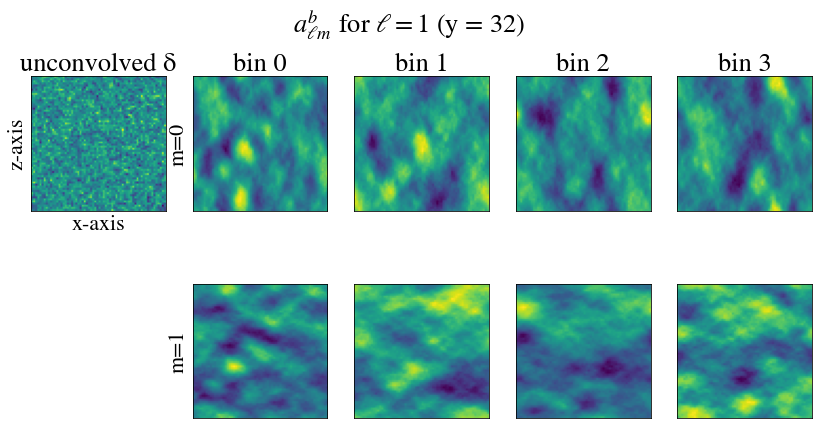

In [227]:
ell = 1
plt.figure(figsize=(14,7))
plt.subplot(2,nbins+1,1)
plt.imshow(data[:,ld_one_d//2,:])
plt.title('unconvolved δ')
plt.xlabel('x-axis')
plt.ylabel('z-axis')
plt.xticks([])
plt.yticks([])

for m in range(2):
    for bin in range(nbins):
        plt.subplot(2,nbins+1,m*(nbins+1)+bin+2)
        ylm_b = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                            '_'+str(m)+'_bin_'+str(bin)+'.npy').astype(np.complex128)
        plt.imshow(ylm_b[:,ld_one_d//2,:].real)
        if m == 0:
            plt.title('bin '+str(bin))
        if bin == 0:
            plt.ylabel('m='+str(m))
        plt.xticks([])
        plt.yticks([])
plt.suptitle("$a_{\ell m}^b$ for $\\ell=1$ (y = " + str(ld_one_d//2) + ")", fontsize='large') 
"""
Remember to denote the x and z axis on the plots and tell the viewer that this is 
the center slice in the y-axis.
"""
plt.show()

## VI) 4PCF Coefficients using Algorithm 3 of ENCORE: Philcox et al. 2021

In [24]:
def S(m):
    """
    A simple function defined in section 4.1.1 of
    Philcox et al. 2021 above algorithm 3.
    """
    if m == 0:
        return 1/2
    return 1

def complex_modulus(z):
    """
    assume z to be an array of complex numbers of the form z = a + ib
    """
    a = np.real(z)
    b = np.imag(z)
    
    return np.sqrt(a**2 + b**2)
    
    

In [25]:
def calc_zeta():
    """
    Calculate zeta hat coefficients for 4PCF on a density field
    """
    zeta = np.zeros((ell_max+1, ell_max+1, ell_max+1,nbins, nbins, nbins)) + 0j
    CG_Coefficients = np.load("CG_Coeffs.npy")
    for l_1 in range(0,ell_max+1):
        for l_2 in range(0,ell_max+1):
            for l_3 in range(np.abs(l_1 - l_2), min(l_1 + l_2, ell_max)+1):
                if (l_1 + l_2 + l_3)%2 != 0: # we don't assume this to be true for Turbulent ISM
                    continue
                for m_1 in range(-l_1, l_1 + 1):
                    for m_2 in range(-l_2, l_2 + 1):
                        m_3 = -m_1 - m_2
                        if m_3 > l_3 or m_3 < 0:
                            continue
                        coupling_w = data * (-1)**(l_1 + l_2 + l_3) * CG_Coefficients[l_1,l_2,l_3,m_1,m_2,m_3]
                        for b_1 in range(0, nbins): #might be an error with indexing here
                            if m_1 < 0:
                                a_lmb_1 = (-1)**m_1 * (np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+
                                        str(l_1)+'_'+str(-m_1)+'_bin_'+str(b_1)+'.npy').astype(np.complex128)).conjugate() 
                            else:
                                a_lmb_1 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l_1)+
                                            '_'+str(m_1)+'_bin_'+str(b_1)+'.npy').astype(np.complex128)
                            for b_2 in range(b_1, nbins):#might be an error with indexing here
                                if m_2 < 0:
                                    a_lmb_2 = (-1)**m_1 * (np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+
                                            str(l_2)+'_'+str(-m_2)+'_bin_'+str(b_2)+'.npy').astype(np.complex128)).conjugate()              
                                else:
                                    a_lmb_2 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l_2)+
                                                '_'+str(m_2)+'_bin_'+str(b_2)+'.npy').astype(np.complex128)
                                for b_3 in range(b_2, nbins):#might be an error with indexing here
                                    a_lmb_3 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l_3)+
                                                '_'+str(m_3)+'_bin_'+str(b_3)+'.npy').astype(np.complex128)
                                    zeta[l_1, l_2, l_3, b_1, b_2, b_3] += np.sum(2 * S(m_3) * 
                                                                            coupling_w * 
                                                                            complex_modulus(a_lmb_1 * a_lmb_2 * a_lmb_3))
    return zeta                               

                                    
                                    
start = time.time()
print("Executing 4PCF Calculation ...")
zeta = calc_zeta()
finish=time.time()

print("Finished Calculating 4PCF in {0:0.4f} seconds".format(finish-start))



Executing 4PCF Calculation ...
Finished Calculating 4PCF in 166.3089 seconds


## VII) Normalize

In [26]:
def normalize_zeta(zeta):
    """
    Normalize zeta^L_B (where L = {\ell_1, \ell_2, \ell_3} and B = {b_1, b_2, b_3}) hat
    coefficients from calc_zeta by dividing by bin volume
    """
    binvolume = boundsandnumber[1,0:nbins]
    normalize_coeff = (binvolume[:,None, None] * binvolume[None,:, None] * binvolume[None, None, :])
    return (zeta/(normalize_coeff*(ld_one_d**3)))


norm_zeta = normalize_zeta(zeta)

In [27]:
#Save zeta

np.save('4pcf_coefficients_normed_GRF_scaled.npy', norm_zeta)